In [165]:
import time
startTime=time.time()

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
model = load_model('.\\checkpoint\\checkpoint873.ckpt')  
model.summary()

#参数
image_shape=(256,256,3)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 256, 256, 4)       112       
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 128, 128, 4)      0         
 g2D)                                                            
                                                                 
 dropout_42 (Dropout)        (None, 128, 128, 4)       0         
                                                                 
 conv2d_43 (Conv2D)          (None, 128, 128, 4)       148       
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 64, 64, 4)        0         
 g2D)                                                            
                                                                 
 dropout_43 (Dropout)        (None, 64, 64, 4)        

In [166]:
#可视化，以及预测单张图片的标签
#img_path = '.\\dataset\\extra_test\\unstable\\unstable-test-030000_Rotate=0.0_o_x=0_o_y=0.png'
img_path = '.\\dataset\\test\\unstable\\unstable-090000_Rotate=320.0_o_x=-10_o_y=10.png'
from tensorflow.keras.preprocessing import image
img = image.load_img(img_path, target_size=(image_shape[0], image_shape[1]))
#print('img=',img)
img_tensor = image.img_to_array(img)
print('img_tensor.shape=',img_tensor.shape)
#print('img_tensor=',img_tensor)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape) 
predictions = model.predict(img_tensor) 
print('predictions=',predictions) 

img_tensor.shape= (256, 256, 3)
(1, 256, 256, 3)
1/1 [==============================] - 0s 105ms/step
predictions= [[0.99998283]]


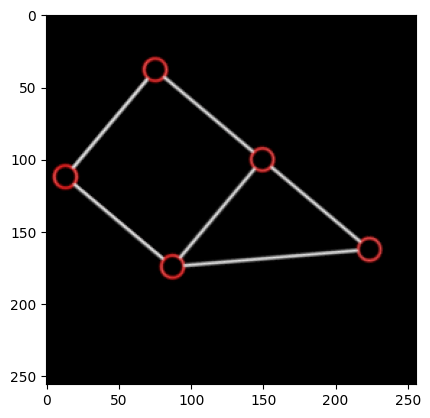

In [167]:
plt.imshow(img_tensor[0])
#cb = plt.colorbar(label='color bar settings') #通过colorbar()函数可以创建最简单的颜色条
plt.show()

In [168]:
#应用Grad-CAM 算法。构建一个同时输出最后一层的卷积层和类别预测结果的网络
from tensorflow.keras import models
last_conv_layer = model.get_layer('conv2d_47') 
heatmap_model =models.Model([model.inputs], [last_conv_layer.output, model.output])

In [169]:
#Grad-CAM 算法实现
import tensorflow.keras.backend as K
with tf.GradientTape() as gtape: #仅以下两行代码需要放入with块中，即求导用的x、y的定义需要放入，其它不需要。
    conv_output, Predictions = heatmap_model(img_tensor) 
    #print('conv_output=',conv_output) #shape=(1, 8, 8, 16)
    #prob = Predictions[:, np.argmax(Predictions[0])] # 最大可能性类别的预测概率。prob= tf.Tensor([1.], shape=(1,), dtype=float32)
    #print('prob=',prob) 
    prob = Predictions[0] # 最大可能性类别的预测概率。prob= tf.Tensor([1.], shape=(1,), dtype=float32)
    #print('prob=',prob)     
grads = gtape.gradient(prob, conv_output)  # 类别与卷积层的梯度
#print('grads=',grads) #shape=(1, 8, 8, 16)
pooled_grads = K.mean(grads, axis=(0,1,2)) # 特征层梯度的全局平均代表每个特征层权重
#print('pooled_grads=',pooled_grads) #shape=(16,)
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1) #权重与特征层相乘，所有层求和平均。tf.reduce_mean 函数计算张量沿着指定轴上的的平均值，主要用作降维或者计算tensor（图像）的平均值。
#print('heatmap[0]=',heatmap[0])
'''
heatmap[0]= tf.Tensor(
[[-2.1301845e-09 -2.4577882e-09 -1.4303507e-09 -2.0479511e-09
  -2.0305095e-09 -7.7271706e-10 -5.3890814e-10 -9.0419522e-10]
 [-8.0601339e-09 -4.4869557e-09  7.7709444e-10  0.0000000e+00
   3.2678478e-09  4.1958570e-09  4.7532902e-09  3.7362056e-09]
 [ 1.3012549e-10  7.0355242e-09 -8.3932274e-09 -1.0343312e-08
   1.8953326e-09  5.9509309e-09  5.6022479e-08  2.7899086e-08]
 [ 2.4228279e-09  0.0000000e+00 -2.1791738e-08 -2.0943322e-08
  -2.8893430e-09 -3.8654392e-08  9.3773060e-08  8.7183274e-08]
 [ 4.7100874e-09  3.2935459e-09 -4.6613444e-08 -1.1834808e-07
  -3.6993576e-08  6.9266748e-09  6.2993095e-08  8.4704602e-08]
 [ 8.6458591e-09  5.4619136e-09  3.0314322e-09  1.6095560e-09
   7.3373387e-09  5.7338019e-09  5.8856777e-08  2.8497681e-08]
 [ 1.3896911e-09 -2.0068214e-09  1.4941478e-09  7.3849521e-10
   1.7184526e-09  1.1009463e-08  4.9075211e-09  4.3670600e-09]
 [-4.7269599e-10  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  5.2961546e-10]], shape=(8, 8), dtype=float32)
'''



'\nheatmap[0]= tf.Tensor(\n[[-2.1301845e-09 -2.4577882e-09 -1.4303507e-09 -2.0479511e-09\n  -2.0305095e-09 -7.7271706e-10 -5.3890814e-10 -9.0419522e-10]\n [-8.0601339e-09 -4.4869557e-09  7.7709444e-10  0.0000000e+00\n   3.2678478e-09  4.1958570e-09  4.7532902e-09  3.7362056e-09]\n [ 1.3012549e-10  7.0355242e-09 -8.3932274e-09 -1.0343312e-08\n   1.8953326e-09  5.9509309e-09  5.6022479e-08  2.7899086e-08]\n [ 2.4228279e-09  0.0000000e+00 -2.1791738e-08 -2.0943322e-08\n  -2.8893430e-09 -3.8654392e-08  9.3773060e-08  8.7183274e-08]\n [ 4.7100874e-09  3.2935459e-09 -4.6613444e-08 -1.1834808e-07\n  -3.6993576e-08  6.9266748e-09  6.2993095e-08  8.4704602e-08]\n [ 8.6458591e-09  5.4619136e-09  3.0314322e-09  1.6095560e-09\n   7.3373387e-09  5.7338019e-09  5.8856777e-08  2.8497681e-08]\n [ 1.3896911e-09 -2.0068214e-09  1.4941478e-09  7.3849521e-10\n   1.7184526e-09  1.1009463e-08  4.9075211e-09  4.3670600e-09]\n [-4.7269599e-10  0.0000000e+00  0.0000000e+00  0.0000000e+00\n   0.0000000e+00  0.0

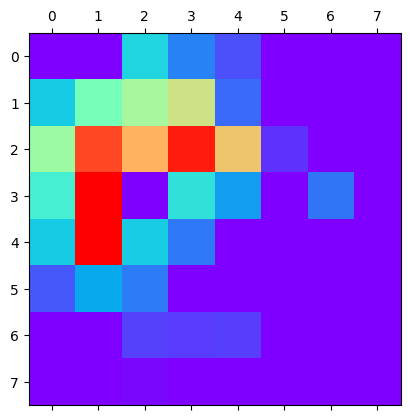

In [170]:
#绘制激活热力图
heatmap = np.maximum(heatmap, 0)
max_heat = np.max(heatmap)
if max_heat == 0:
    max_heat = 1e-10
heatmap /= max_heat
#plt.matshow(heatmap[0], cmap='viridis') #从紫、蓝、绿、黄过渡渐变
plt.matshow(heatmap[0],cmap='rainbow') #红、橙、黄、绿、青、蓝、紫。     红色值最大、紫色最小




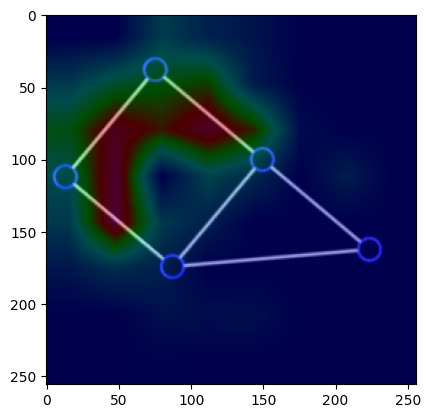

How many seconds: 46.161439657211304


In [173]:
#与原有图片进行加权叠加
import cv2
original_img=cv2.imread(img_path) 
#print('original_img.shape=',original_img.shape) #original_img.shape= (256, 256, 3)
#heatmap1 = cv2.resize(heatmap[0], (original_img.shape[1], original_img.shape[0]), interpolation=cv2.INTER_CUBIC) #interpolation是像素插值方法
heatmap1 = cv2.resize(heatmap[0], (original_img.shape[1], original_img.shape[0])) 
heatmap1 = np.uint8(255*heatmap1)
heatmap1 = cv2.applyColorMap(heatmap1, cv2.COLORMAP_RAINBOW)
frame_out=cv2.addWeighted(original_img,0.7,heatmap1,0.3,0) #图像叠加权重
#cv2.imwrite('Visualizing heatmaps of class activation.jpg', frame_out) #保存到硬盘
plt.figure()
plt.imshow(frame_out)
plt.show()

#前三类结果比较。首先使用如下代买对预测的最大值进行修改，得到第二和第三可能性的预测结果
#Predictions3=Predictions.numpy()
#Predictions3[0][np.argmax(Predictions3[0])]=np.min(Predictions3)
#Predictions3[0][np.argmax(Predictions3[0])]=np.min(Predictions3)
#plt.show()


endTime=time.time()
print('How many seconds:',(endTime-startTime))